In [68]:
import dask.dataframe as dd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from scipy import stats
%matplotlib inline

In [2]:
home_df = dd.read_csv("D:\home_weekly_20211029.csv", dtype={'brands': 'object',
                                                            'distance_from_home': 'float64',
                                                           'area_square_feet': 'float64',
                                                            'opened_on': 'object',
                                                            'parent_placekey': 'object',
                                                            'safegraph_brand_ids': 'object',
                                                            'tracking_opened_since': 'object',
                                                            'category_tags': 'object',
                                                                        'poi_cbg':'object'}) # dtype to avoid error using dask

In [3]:
home_df.head()

,placekey,date_range_start,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
0,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360050001000,4,0.000000,0.500000,0.000000,0.000000
1,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360470437004,4,9.974576,0.018433,0.018433,2.690041
2,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360470493005,4,8.588745,0.020101,0.020101,2.316296
3,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360471134003,4,2.479008,0.008333,0.008333,0.668563
4,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360471196002,4,0.212593,0.001224,0.001224,0.057334


In [3]:
home_df=home_df.compute()

In [5]:
home_df.shape

(27825638, 8)

In [4]:
home_df['date_range_start'] = pd.to_datetime(home_df['date_range_start'], infer_datetime_format=True, utc=True)
home_df['date'] = home_df['date_range_start'].dt.date

In [5]:
#按date 的总 visit

sameday_total = home_df.groupby('date').agg({'visitor_count':'sum', 'estimated_visitor_count':'sum'}) 
sameday_total.head(2)

,visitor_count,estimated_visitor_count
date,,
2018-12-31,1272490,2.928497e+06
2019-01-07,1383496,3.003713e+06


In [6]:
df=home_df

df=pd.merge(df,sameday_total,how='right',left_on='date',right_on='date')
df.head()

,placekey,date_range_start,home_cbg,visitor_count_x,estimated_visitor_count_x,pct_visitor_count,pct_estimated_visitor_count,cdi,date,visitor_count_y,estimated_visitor_count_y
0,22t-222@627-s7m-rtv,2018-12-31 05:00:00+00:00,360050001000,4,0.000000,0.500000,0.000000,0.000000,2018-12-31,1272490,2.928497e+06
1,22t-222@627-s7m-rtv,2018-12-31 05:00:00+00:00,360470437004,4,9.974576,0.018433,0.018433,2.690041,2018-12-31,1272490,2.928497e+06
2,22t-222@627-s7m-rtv,2018-12-31 05:00:00+00:00,360470493005,4,8.588745,0.020101,0.020101,2.316296,2018-12-31,1272490,2.928497e+06
3,22t-222@627-s7m-rtv,2018-12-31 05:00:00+00:00,360471134003,4,2.479008,0.008333,0.008333,0.668563,2018-12-31,1272490,2.928497e+06
4,22t-222@627-s7m-rtv,2018-12-31 05:00:00+00:00,360471196002,4,0.212593,0.001224,0.001224,0.057334,2018-12-31,1272490,2.928497e+06


In [7]:
df=df.rename(columns={'visitor_count_x':'visitor_count','estimated_visitor_count_x':'estimated_visitor_count','visitor_count_y':'totalvisitor_sameday','estimated_visitor_count_y':'totalvisitor_est_sameday'})
df['visitor_pct']=df['visitor_count']/df['totalvisitor_sameday']
df['visitor_est_pct']=df['estimated_visitor_count']/df['totalvisitor_est_sameday']

In [15]:
df.head()

,placekey,date_range_start,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,date,totalvisitor_sameday,totalvisitor_est_sameday,visitor_pct,visitor_est_pct
0,22t-222@627-s7m-rtv,2018-12-31 05:00:00+00:00,360050001000,4,0.000000,0.500000,0.000000,0.000000,2018-12-31,1272490,2.928497e+06,0.000003,0.000000e+00
1,22t-222@627-s7m-rtv,2018-12-31 05:00:00+00:00,360470437004,4,9.974576,0.018433,0.018433,2.690041,2018-12-31,1272490,2.928497e+06,0.000003,3.406040e-06
2,22t-222@627-s7m-rtv,2018-12-31 05:00:00+00:00,360470493005,4,8.588745,0.020101,0.020101,2.316296,2018-12-31,1272490,2.928497e+06,0.000003,2.932817e-06
3,22t-222@627-s7m-rtv,2018-12-31 05:00:00+00:00,360471134003,4,2.479008,0.008333,0.008333,0.668563,2018-12-31,1272490,2.928497e+06,0.000003,8.465120e-07
4,22t-222@627-s7m-rtv,2018-12-31 05:00:00+00:00,360471196002,4,0.212593,0.001224,0.001224,0.057334,2018-12-31,1272490,2.928497e+06,0.000003,7.259462e-08


In [8]:
df=df[['placekey','home_cbg','date','visitor_pct','visitor_est_pct']]
df.head()

,placekey,home_cbg,date,visitor_pct,visitor_est_pct
0,22t-222@627-s7m-rtv,360050001000,2018-12-31,0.000003,0.000000e+00
1,22t-222@627-s7m-rtv,360470437004,2018-12-31,0.000003,3.406040e-06
2,22t-222@627-s7m-rtv,360470493005,2018-12-31,0.000003,2.932817e-06
3,22t-222@627-s7m-rtv,360471134003,2018-12-31,0.000003,8.465120e-07
4,22t-222@627-s7m-rtv,360471196002,2018-12-31,0.000003,7.259462e-08


In [9]:
poi=dd.read_csv("D:\poi_health_recategorized.csv")

In [10]:
poi.head()

,placekey,cbg,naics_code,category,sub_category,location_name,area_square_feet,latitude,longitude
0,226-222@627-s4n-pqf,360610158022,311811,Snacks and Bakeries,Retail Bakeries,Unna Bakery,NaN,40.787027,-73.950435
1,225-225@627-s99-9xq,360810849002,311811,Snacks and Bakeries,Retail Bakeries,Fay Da Bakery,24759.0,40.756244,-73.829009
2,225-225@627-vsw-7nq,360850146071,311811,Snacks and Bakeries,Retail Bakeries,Amici Bakery,16166.0,40.559894,-74.166016
3,22b-222@627-s7s-jqf,360810475001,311811,Snacks and Bakeries,Retail Bakeries,Sunrise Bakery & Cafe,732.0,40.736802,-73.879306
4,23h-222@627-s9z-n3q,360810779071,311811,Snacks and Bakeries,Retail Bakeries,Avraham Bakery,12069.0,40.724409,-73.820241


In [10]:
poi=poi.compute()
poi.sub_category.unique()

array(['Retail Bakeries', 'Delis and Convenience Stores',
       'Supermarkets and Other Grocery (except Convenience) Stores',
       'Meat Markets', 'Fish and Seafood Markets',
       'Fruit and Vegetable Markets', 'Baked Goods Stores',
       'Confectionery and Nut Stores', 'All Other Specialty Food Stores',
       'Beer, Wine, and Liquor Stores', 'Pharmacies and Drug Stores',
       'Food (Health) Supplement Stores', 'Department Stores',
       'All Other General Merchandise Stores', 'Tobacco Stores',
       'All Other Miscellaneous Store Retailers (except Tobacco Stores)',
       'Community Food Services', 'Caterers',
       'Drinking Places (Alcoholic Beverages)',
       'Full-Service Restaurants', 'Fast-Food Restaurants',
       'Limited-Service Restaurants',
       'Snack and Nonalcoholic Beverage Bars'], dtype=object)

In [11]:
poi=poi[['placekey','sub_category']]
poi=poi.drop_duplicates()

In [12]:
df=pd.merge(df,poi,how='left',left_on='placekey',right_on='placekey')


In [ ]:
#df_join.to_csv('D:\df join.csv', index=None)

In [ ]:
#df_join.head(20)

In [22]:
df.head()

,placekey,home_cbg,date,visitor_pct,visitor_est_pct,sub_category
0,22t-222@627-s7m-rtv,360050001000,2018-12-31,0.000003,0.000000e+00,Full-Service Restaurants
1,22t-222@627-s7m-rtv,360470437004,2018-12-31,0.000003,3.406040e-06,Full-Service Restaurants
2,22t-222@627-s7m-rtv,360470493005,2018-12-31,0.000003,2.932817e-06,Full-Service Restaurants
3,22t-222@627-s7m-rtv,360471134003,2018-12-31,0.000003,8.465120e-07,Full-Service Restaurants
4,22t-222@627-s7m-rtv,360471196002,2018-12-31,0.000003,7.259462e-08,Full-Service Restaurants


In [23]:
df.shape

(27825638, 6)

In [15]:
def repair_dates(df):
    df['date'] = pd.to_datetime(df['date'], utc=True)
    df['date'] = df['date'].dt.tz_convert('US/Eastern')

In [21]:
df_sc=df[(df['sub_category']=='Supermarkets and Other Grocery (except Convenience) Stores')|(df['sub_category']=='Delis and Convenience Stores')]

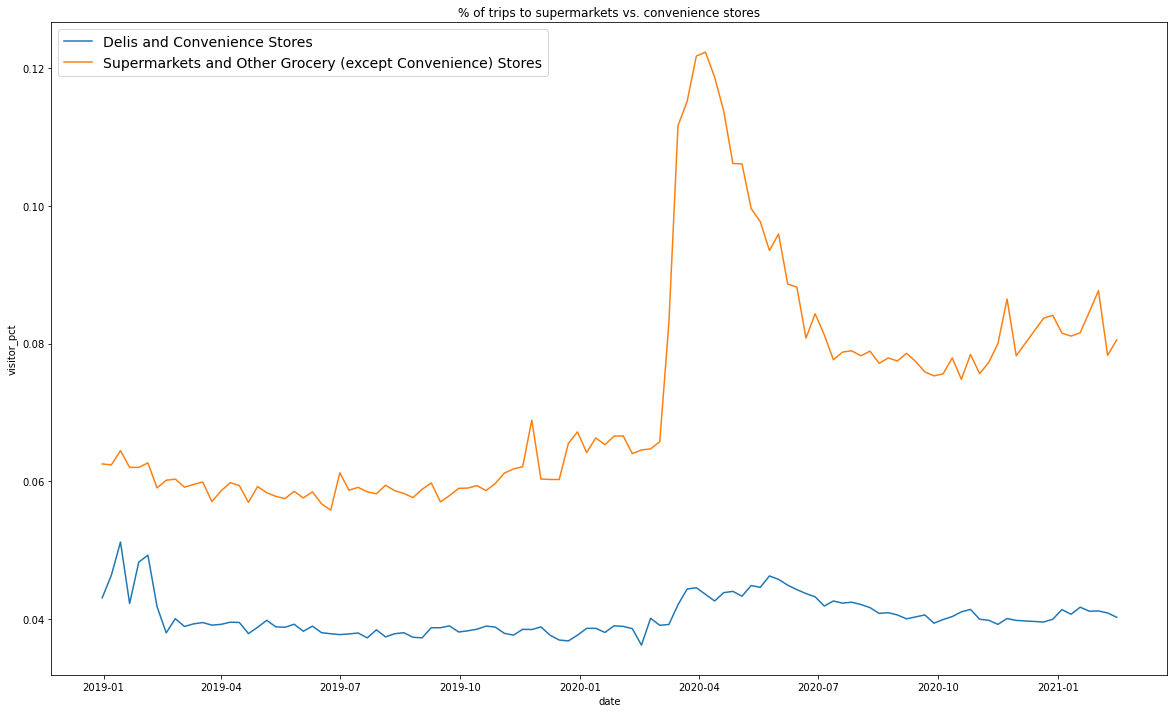

In [22]:
df_sc = df_sc.groupby(['sub_category','date']).agg({'visitor_pct':'sum','visitor_est_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= df_sc, x="date", y="visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("% of trips to supermarkets vs. convenience stores")
plt.show()

In [23]:
df_sc=df_sc.reset_index()
repair_dates(df_sc)
df_sc['year'] = df_sc['date'].dt.year
df_sc['week'] = df_sc['date'].dt.week
df_sc.head()
df_sc_2019=df_sc[df_sc.year==2019]
df_sc_2020=df_sc[df_sc.year==2020]


In [24]:

diff_df_sc = pd.merge(df_sc_2019[['sub_category','week','visitor_pct']],df_sc_2020[['sub_category','week','visitor_pct']], on= ['sub_category', 'week'])
diff_df_sc['diff_visitor_pct']=diff_df_sc['visitor_pct_y']-diff_df_sc['visitor_pct_x']
    

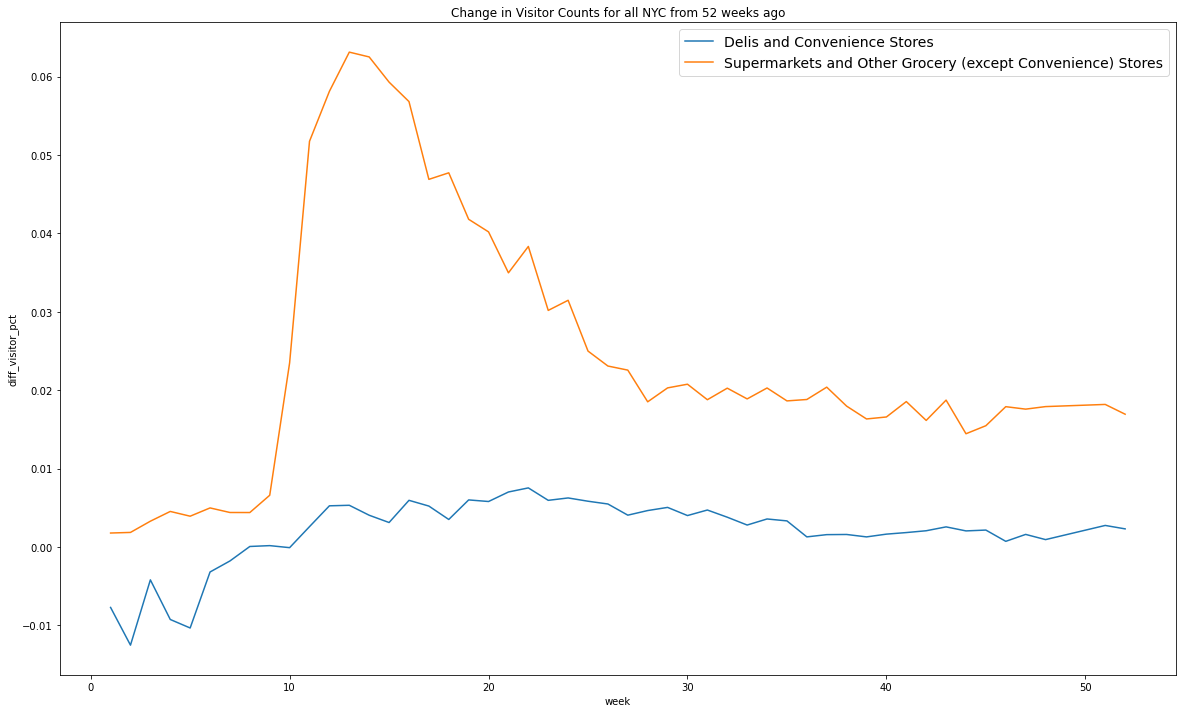

In [25]:
plt.figure(figsize=(20,12))
sns.lineplot(data= diff_df_sc, x="week", y="diff_visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("Change in Visitor Counts for all NYC from 52 weeks ago")
plt.show()

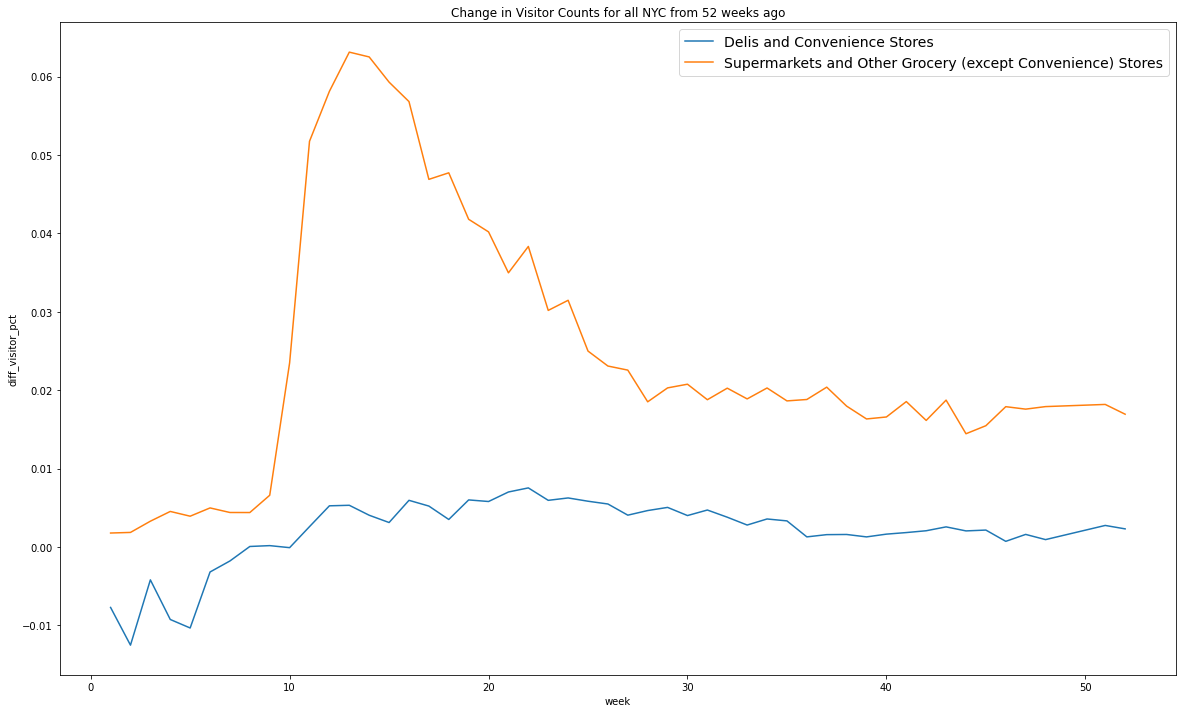

In [31]:
diff_df_sc = diff_df_sc.groupby(['sub_category','week']).agg({'diff_visitor_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= diff_df_sc, x="week", y="diff_visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("Change in Visitor Counts for all NYC from 52 weeks ago")
plt.show()

In [32]:
#Diff 
#Cluster
#percentage %
#column name

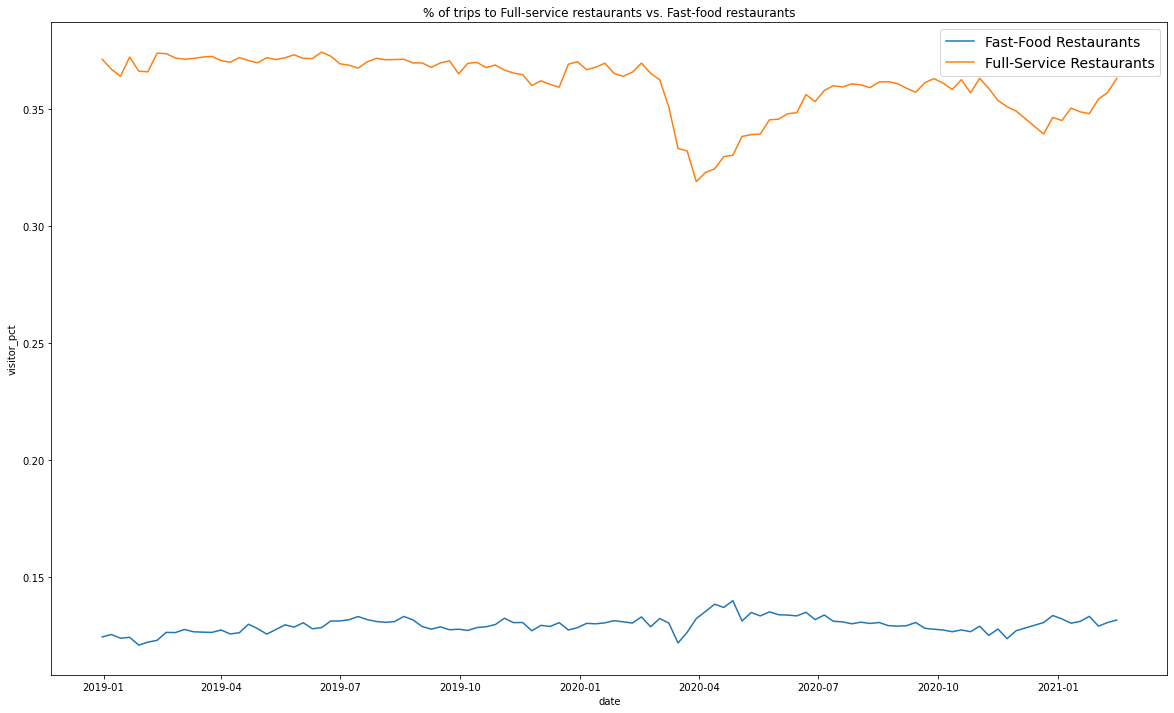

In [33]:
df_ff=df[(df['sub_category']=='Full-Service Restaurants')|(df['sub_category']=='Fast-Food Restaurants')]
df_ff = df_ff.groupby(['sub_category','date']).agg({'visitor_pct':'sum','visitor_est_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= df_ff, x="date", y="visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("% of trips to Full-service restaurants vs. Fast-food restaurants")
plt.show()

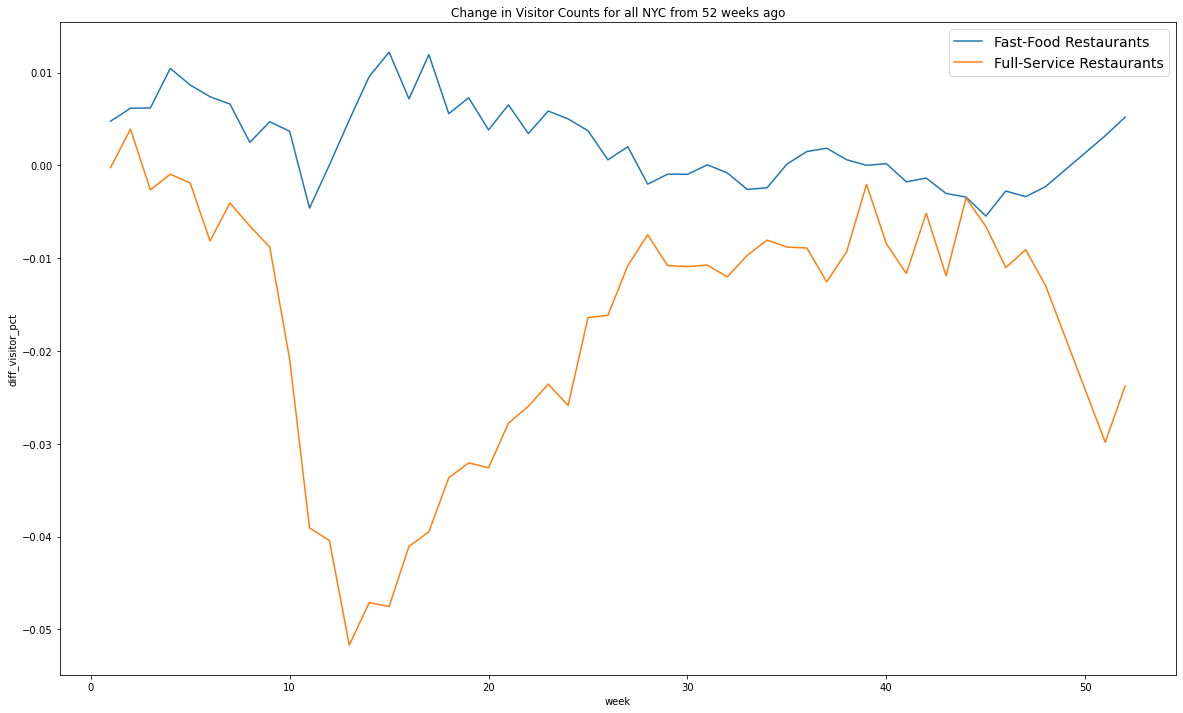

In [34]:
df_ff=df_ff.reset_index()
repair_dates(df_ff)
df_ff['year'] = df_ff['date'].dt.year
df_ff['week'] = df_ff['date'].dt.week

df_ff_2019=df_ff[df_ff.year==2019]
df_ff_2020=df_ff[df_ff.year==2020]

diff_df_ff = pd.merge(df_ff_2019[['sub_category','week','visitor_pct']],df_ff_2020[['sub_category','week','visitor_pct']], on= ['sub_category', 'week'])
diff_df_ff['diff_visitor_pct']=diff_df_ff['visitor_pct_y']-diff_df_ff['visitor_pct_x']
    
plt.figure(figsize=(20,12))
sns.lineplot(data= diff_df_ff, x="week", y="diff_visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("Change in Visitor Counts for all NYC from 52 weeks ago")
plt.show()

In [35]:
cluster= pd.read_csv('D:\proximity_clusters.csv')

In [36]:
cluster=cluster[['cbg','cluster']]
cluster

,cbg,cluster
0,360050001001,3
1,360050002001,3
2,360050002002,2
3,360050002003,1
4,360050004001,1
...,...,...
6211,360850319012,2
6212,360850319021,3
6213,360850319022,2
6214,360850319023,2


In [37]:
df_sc=df[(df['sub_category']=='Supermarkets and Other Grocery (except Convenience) Stores')|(df['sub_category']=='Delis and Convenience Stores')]
df_sc

,placekey,home_cbg,date,visitor_pct,visitor_est_pct,sub_category
172,222-222@627-sbc-fj9,360050002001,2018-12-31,0.000003,0.000005,Supermarkets and Other Grocery (except Conveni...
173,222-222@627-sbc-fj9,360050020004,2018-12-31,0.000003,0.000002,Supermarkets and Other Grocery (except Conveni...
174,222-222@627-sbc-fj9,360050383013,2018-12-31,0.000003,0.000004,Supermarkets and Other Grocery (except Conveni...
175,222-222@627-sbc-fj9,360610223012,2018-12-31,0.000003,0.000004,Supermarkets and Other Grocery (except Conveni...
176,222-222@627-sbc-fj9,360810185022,2018-12-31,0.000003,0.000005,Supermarkets and Other Grocery (except Conveni...
...,...,...,...,...,...,...
27825611,228-224@627-vv3-dsq,360850277052,2021-02-15,0.000008,0.000004,Supermarkets and Other Grocery (except Conveni...
27825620,228-222@627-s93-cnq,360850291032,2021-02-15,0.000008,0.000005,Delis and Convenience Stores
27825633,225-222@627-wf5-3nq,360850303021,2021-02-15,0.000008,0.000005,Delis and Convenience Stores
27825635,22f-226@627-s8j-mc5,360850319022,2021-02-15,0.000008,0.000006,Delis and Convenience Stores


In [38]:
df_sc_cluster=pd.merge(df_sc,cluster,left_on='home_cbg',right_on='cbg')

In [39]:
df_sc_cluster

,placekey,home_cbg,date,visitor_pct,visitor_est_pct,sub_category,cbg,cluster
0,222-222@627-sbc-fj9,360050002001,2018-12-31,0.000003,0.000005,Supermarkets and Other Grocery (except Conveni...,360050002001,3
1,zzw-222@627-rwm-7dv,360050002001,2018-12-31,0.000003,0.000005,Supermarkets and Other Grocery (except Conveni...,360050002001,3
2,234-223@627-rwr-3yv,360050002001,2018-12-31,0.000003,0.000005,Supermarkets and Other Grocery (except Conveni...,360050002001,3
3,234-222@627-rwr-3yv,360050002001,2018-12-31,0.000003,0.000005,Supermarkets and Other Grocery (except Conveni...,360050002001,3
4,233-223@627-s6k-q4v,360050002001,2018-12-31,0.000003,0.000005,Supermarkets and Other Grocery (except Conveni...,360050002001,3
...,...,...,...,...,...,...,...,...
2882636,zzw-223@627-s82-52k,360810050001,2020-10-19,0.000005,0.000006,Delis and Convenience Stores,360810050001,3
2882637,225-222@627-s93-bff,360470531004,2020-09-21,0.000006,0.000018,Delis and Convenience Stores,360470531004,1
2882638,zzy-222@627-s7q-qcq,360470531004,2020-10-12,0.000006,0.000017,Supermarkets and Other Grocery (except Conveni...,360470531004,1
2882639,224-222@627-s7r-d9z,360470531004,2020-10-12,0.000006,0.000017,Delis and Convenience Stores,360470531004,1


In [40]:
df_sc_cluster_0=df_sc_cluster[df_sc_cluster['cluster']==0]
df_sc_cluster_1=df_sc_cluster[df_sc_cluster['cluster']==1]
df_sc_cluster_2=df_sc_cluster[df_sc_cluster['cluster']==2]
df_sc_cluster_3=df_sc_cluster[df_sc_cluster['cluster']==3]

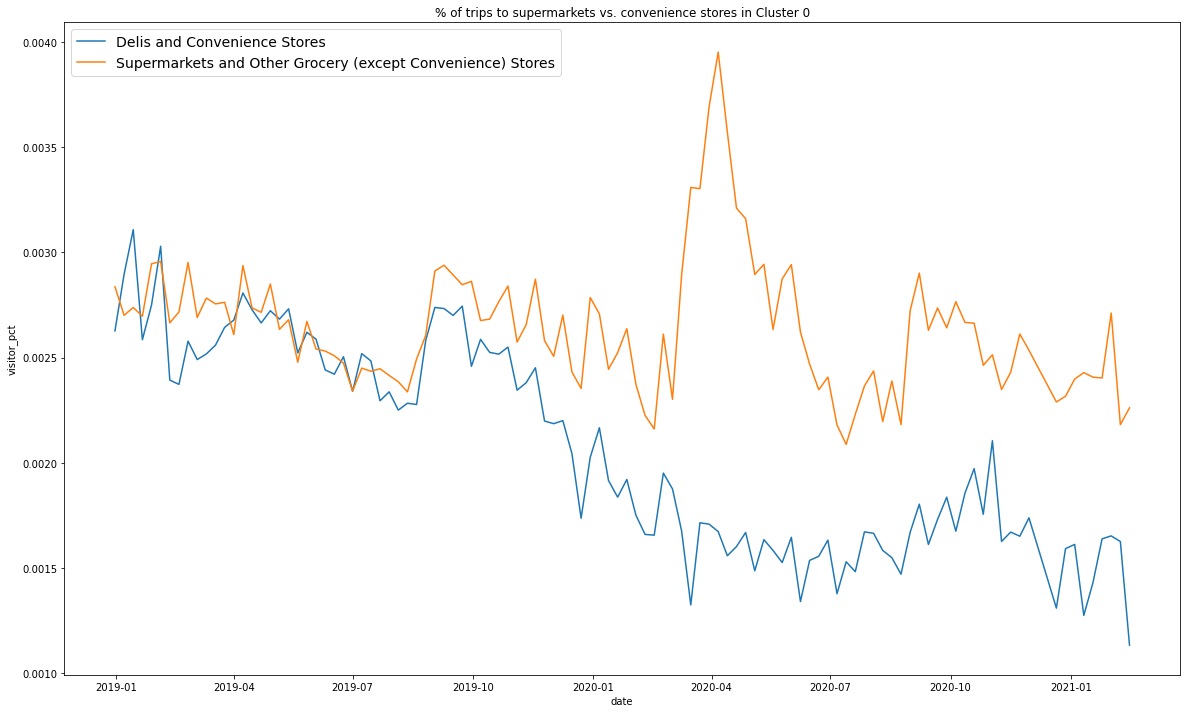

In [41]:
df_sc_cluster_0 = df_sc_cluster_0.groupby(['sub_category','date']).agg({'visitor_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= df_sc_cluster_0, x="date", y="visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("% of trips to supermarkets vs. convenience stores in Cluster 0")
plt.show()

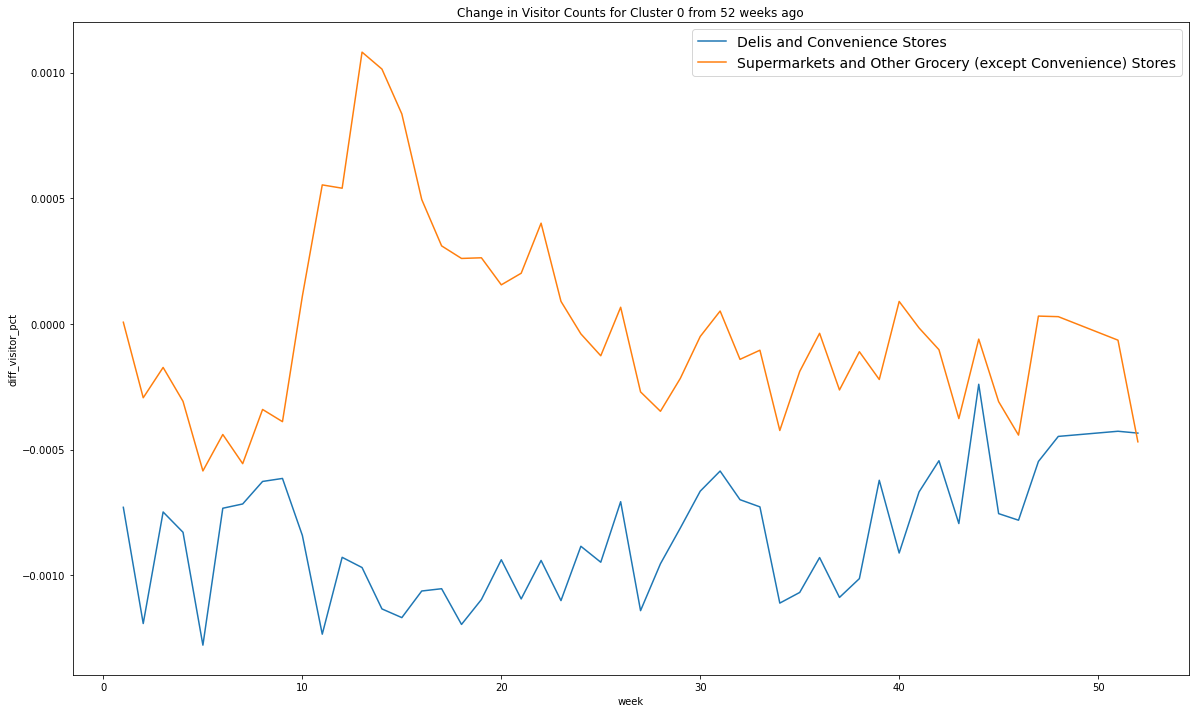

In [42]:
df_sc_cluster_0=df_sc_cluster_0.reset_index()
repair_dates(df_sc_cluster_0)
df_sc_cluster_0['year'] = df_sc_cluster_0['date'].dt.year
df_sc_cluster_0['week'] = df_sc_cluster_0['date'].dt.week

df_sc_cluster_0_2019=df_sc_cluster_0[df_sc_cluster_0.year==2019]
df_sc_cluster_0_2020=df_sc_cluster_0[df_sc_cluster_0.year==2020]

diff_df_sc_cluster_0 = pd.merge(df_sc_cluster_0_2019[['sub_category','week','visitor_pct']],df_sc_cluster_0_2020[['sub_category','week','visitor_pct']], on= ['sub_category', 'week'])
diff_df_sc_cluster_0['diff_visitor_pct']=diff_df_sc_cluster_0['visitor_pct_y']-diff_df_sc_cluster_0['visitor_pct_x']
    
plt.figure(figsize=(20,12))
sns.lineplot(data= diff_df_sc_cluster_0, x="week", y="diff_visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("Change in Visitor Counts for Cluster 0 from 52 weeks ago")
plt.show()

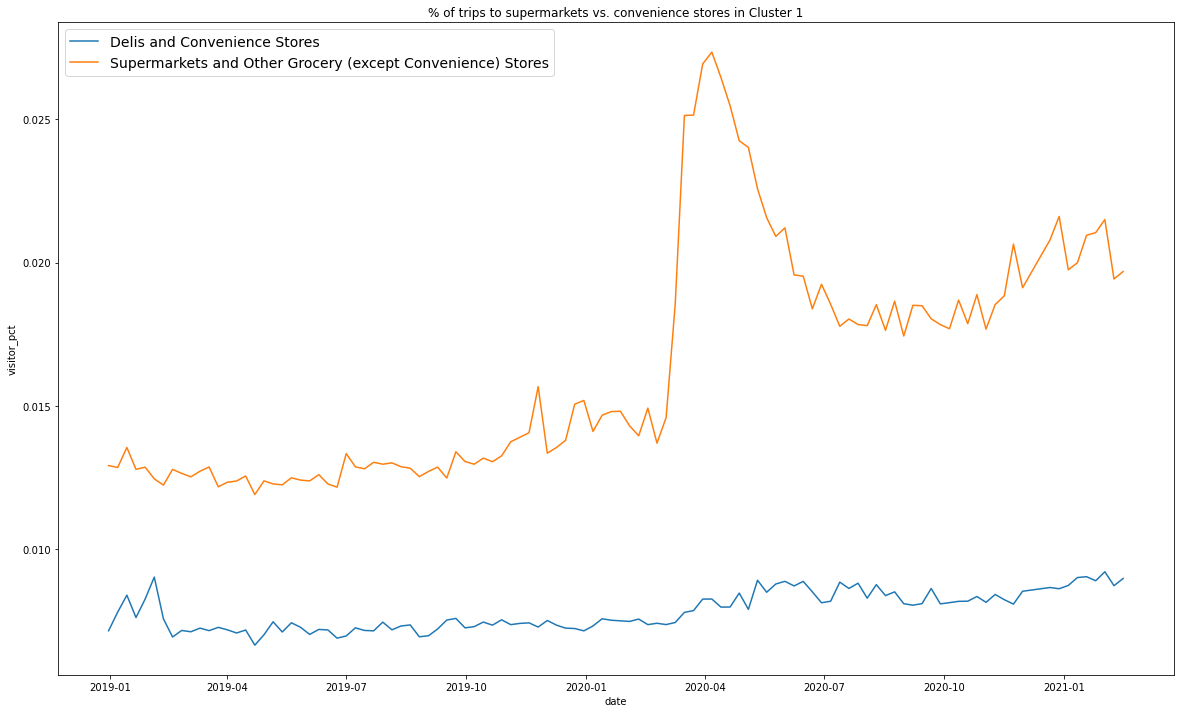

In [43]:
df_sc_cluster_1 = df_sc_cluster_1.groupby(['sub_category','date']).agg({'visitor_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= df_sc_cluster_1, x="date", y="visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("% of trips to supermarkets vs. convenience stores in Cluster 1")
plt.show()

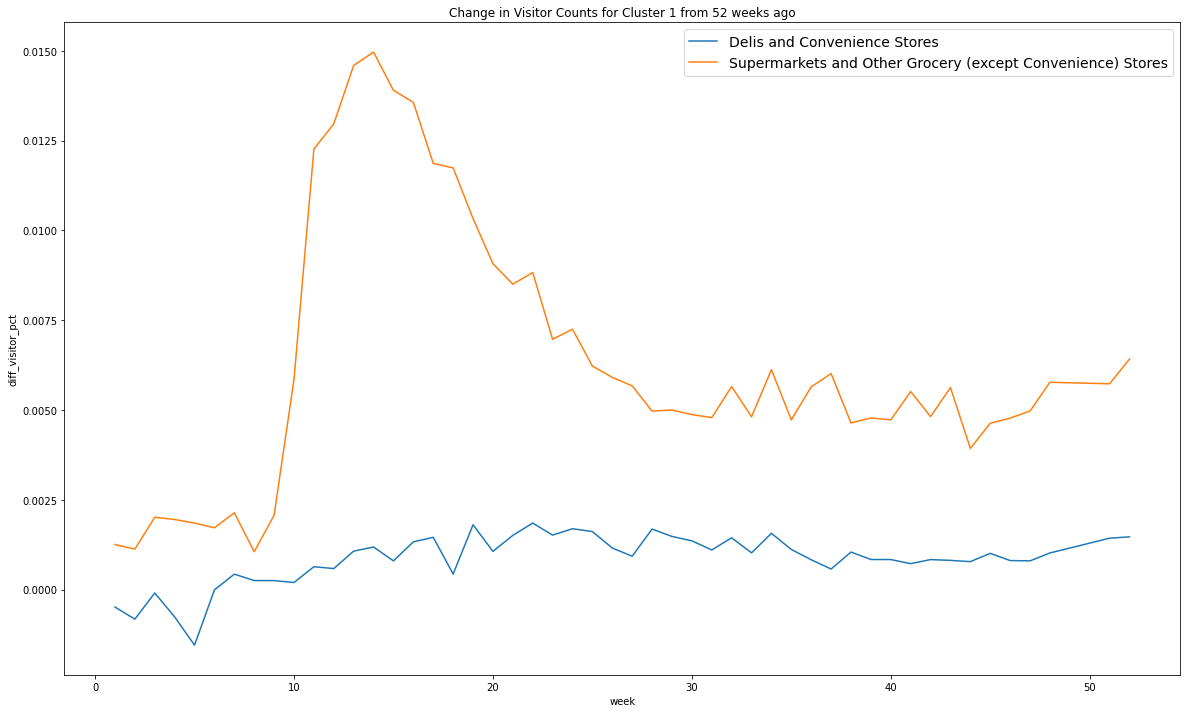

In [44]:
df_sc_cluster_1=df_sc_cluster_1.reset_index()
repair_dates(df_sc_cluster_1)
df_sc_cluster_1['year'] = df_sc_cluster_1['date'].dt.year
df_sc_cluster_1['week'] = df_sc_cluster_1['date'].dt.week

df_sc_cluster_1_2019=df_sc_cluster_1[df_sc_cluster_1.year==2019]
df_sc_cluster_1_2020=df_sc_cluster_1[df_sc_cluster_1.year==2020]

diff_df_sc_cluster_1 = pd.merge(df_sc_cluster_1_2019[['sub_category','week','visitor_pct']],df_sc_cluster_1_2020[['sub_category','week','visitor_pct']], on= ['sub_category', 'week'])
diff_df_sc_cluster_1['diff_visitor_pct']=diff_df_sc_cluster_1['visitor_pct_y']-diff_df_sc_cluster_1['visitor_pct_x']
    
plt.figure(figsize=(20,12))
sns.lineplot(data= diff_df_sc_cluster_1, x="week", y="diff_visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("Change in Visitor Counts for Cluster 1 from 52 weeks ago")
plt.show()

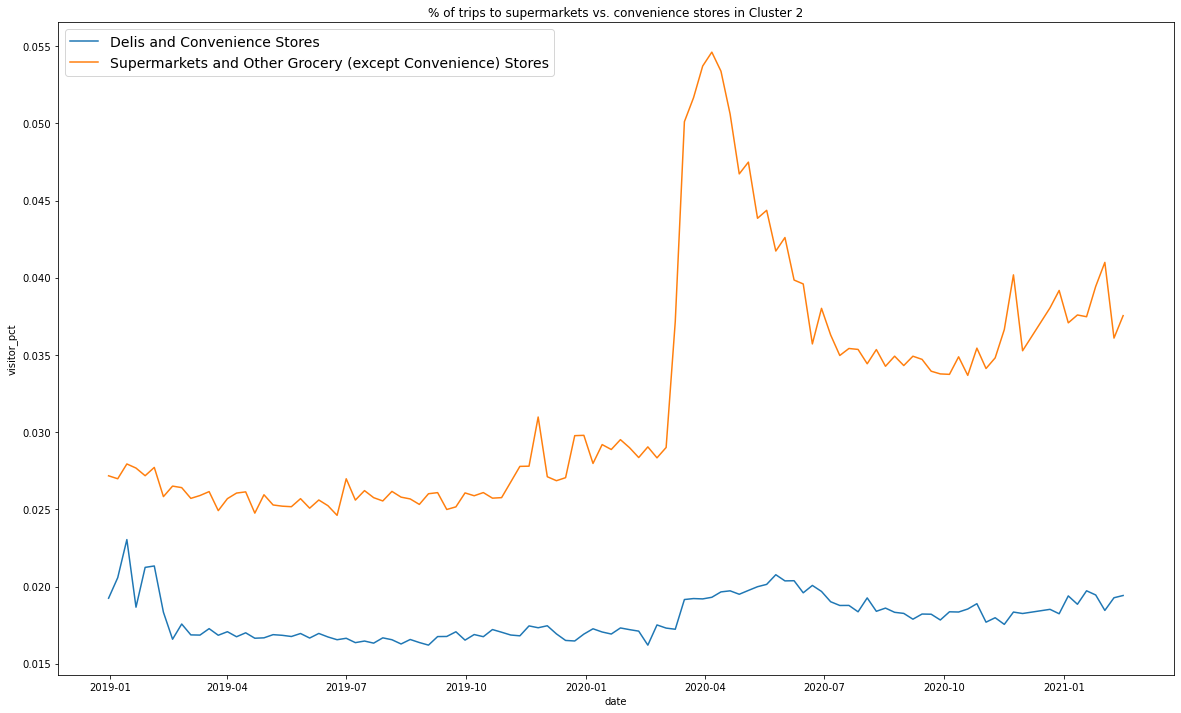

In [45]:
df_sc_cluster_2 = df_sc_cluster_2.groupby(['sub_category','date']).agg({'visitor_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= df_sc_cluster_2, x="date", y="visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("% of trips to supermarkets vs. convenience stores in Cluster 2")
plt.show()

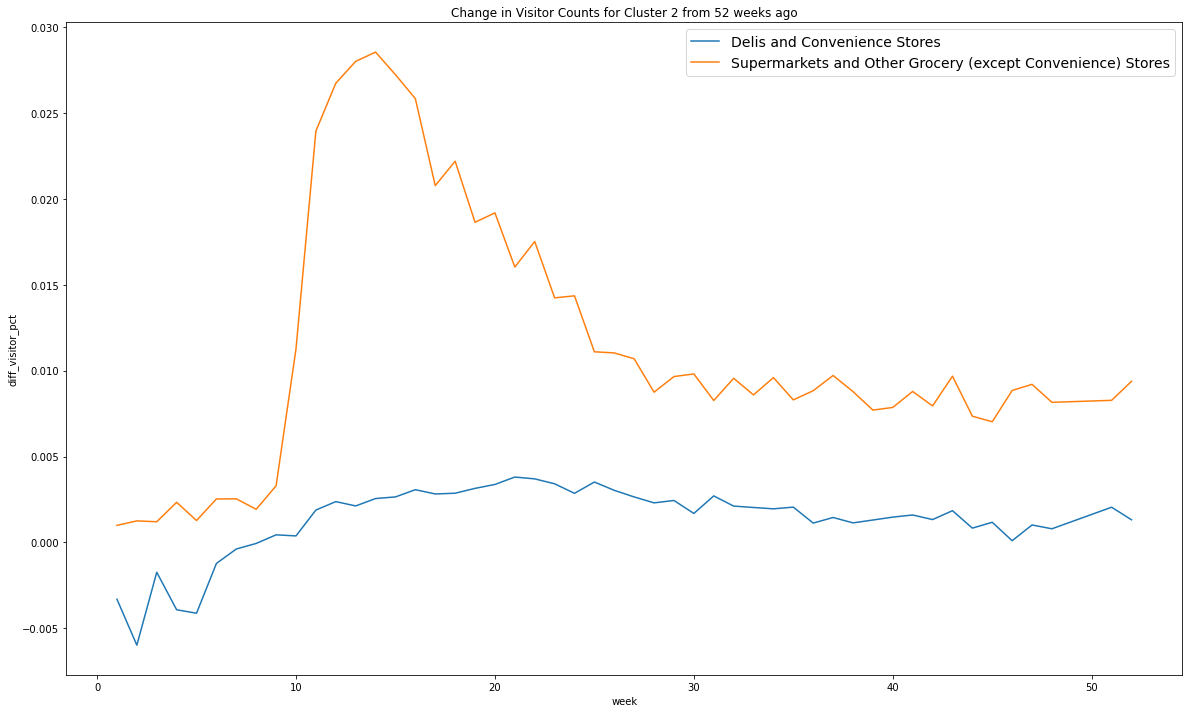

In [46]:
df_sc_cluster_2=df_sc_cluster_2.reset_index()
repair_dates(df_sc_cluster_2)
df_sc_cluster_2['year'] = df_sc_cluster_2['date'].dt.year
df_sc_cluster_2['week'] = df_sc_cluster_2['date'].dt.week

df_sc_cluster_2_2019=df_sc_cluster_2[df_sc_cluster_2.year==2019]
df_sc_cluster_2_2020=df_sc_cluster_2[df_sc_cluster_2.year==2020]

diff_df_sc_cluster_2 = pd.merge(df_sc_cluster_2_2019[['sub_category','week','visitor_pct']],df_sc_cluster_2_2020[['sub_category','week','visitor_pct']], on= ['sub_category', 'week'])
diff_df_sc_cluster_2['diff_visitor_pct']=diff_df_sc_cluster_2['visitor_pct_y']-diff_df_sc_cluster_2['visitor_pct_x']
    
plt.figure(figsize=(20,12))
sns.lineplot(data= diff_df_sc_cluster_2, x="week", y="diff_visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("Change in Visitor Counts for Cluster 2 from 52 weeks ago")
plt.show()

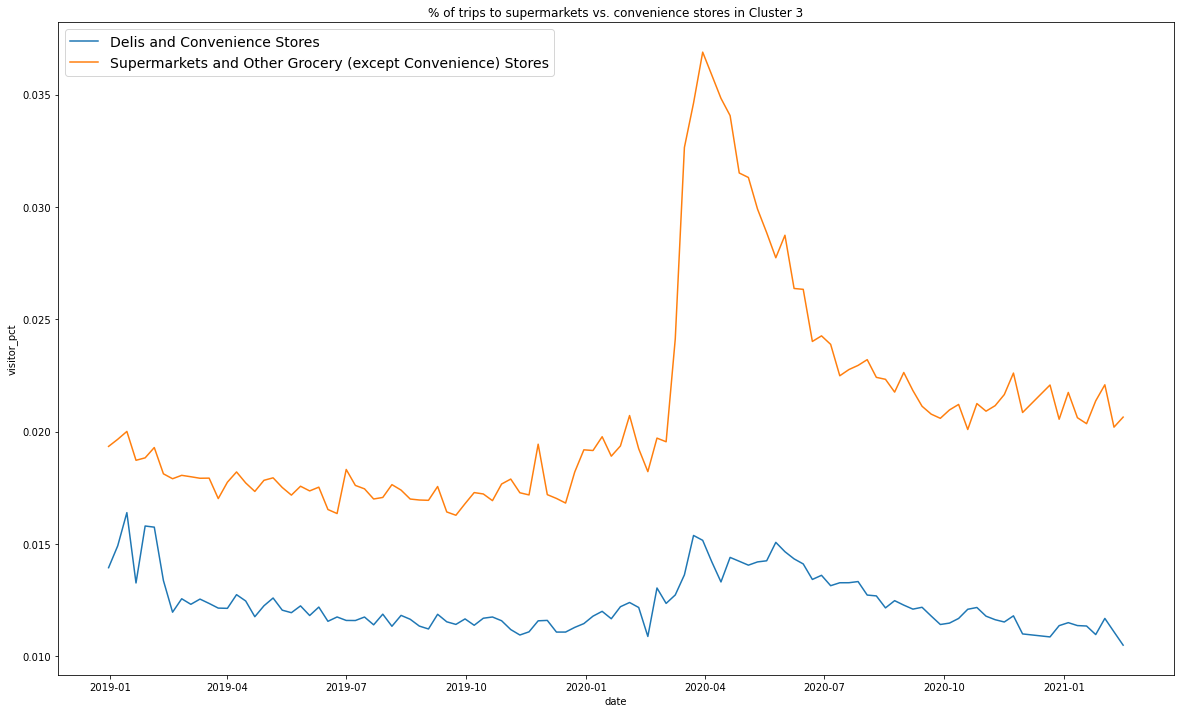

In [47]:
df_sc_cluster_3 = df_sc_cluster_3.groupby(['sub_category','date']).agg({'visitor_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= df_sc_cluster_3, x="date", y="visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("% of trips to supermarkets vs. convenience stores in Cluster 3")
plt.show()

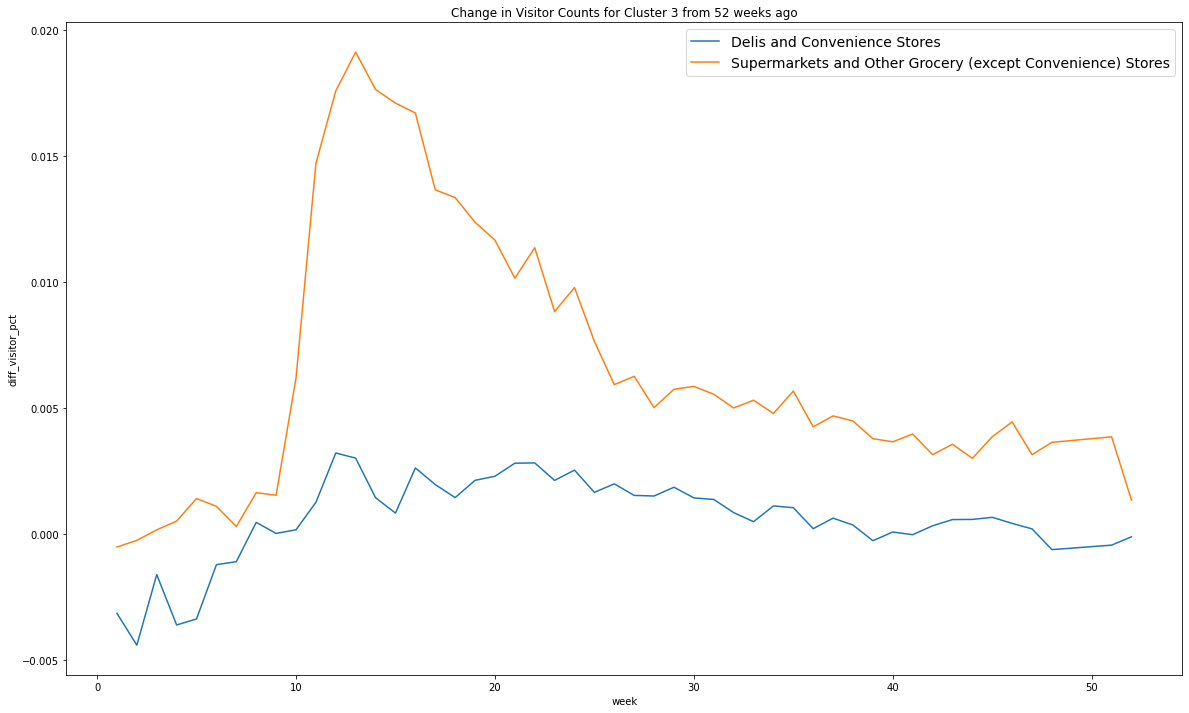

In [48]:
df_sc_cluster_3=df_sc_cluster_3.reset_index()
repair_dates(df_sc_cluster_3)
df_sc_cluster_3['year'] = df_sc_cluster_3['date'].dt.year
df_sc_cluster_3['week'] = df_sc_cluster_3['date'].dt.week

df_sc_cluster_3_2019=df_sc_cluster_3[df_sc_cluster_3.year==2019]
df_sc_cluster_3_2020=df_sc_cluster_3[df_sc_cluster_3.year==2020]

diff_df_sc_cluster_3 = pd.merge(df_sc_cluster_3_2019[['sub_category','week','visitor_pct']],df_sc_cluster_3_2020[['sub_category','week','visitor_pct']], on= ['sub_category', 'week'])
diff_df_sc_cluster_3['diff_visitor_pct']=diff_df_sc_cluster_3['visitor_pct_y']-diff_df_sc_cluster_3['visitor_pct_x']
    
plt.figure(figsize=(20,12))
sns.lineplot(data= diff_df_sc_cluster_3, x="week", y="diff_visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("Change in Visitor Counts for Cluster 3 from 52 weeks ago")
plt.show()

In [49]:
df_ff=df[(df['sub_category']=='Full-Service Restaurants')|(df['sub_category']=='Fast-Food Restaurants')]
df_ff_cluster=pd.merge(df_ff,cluster,left_on='home_cbg',right_on='cbg')

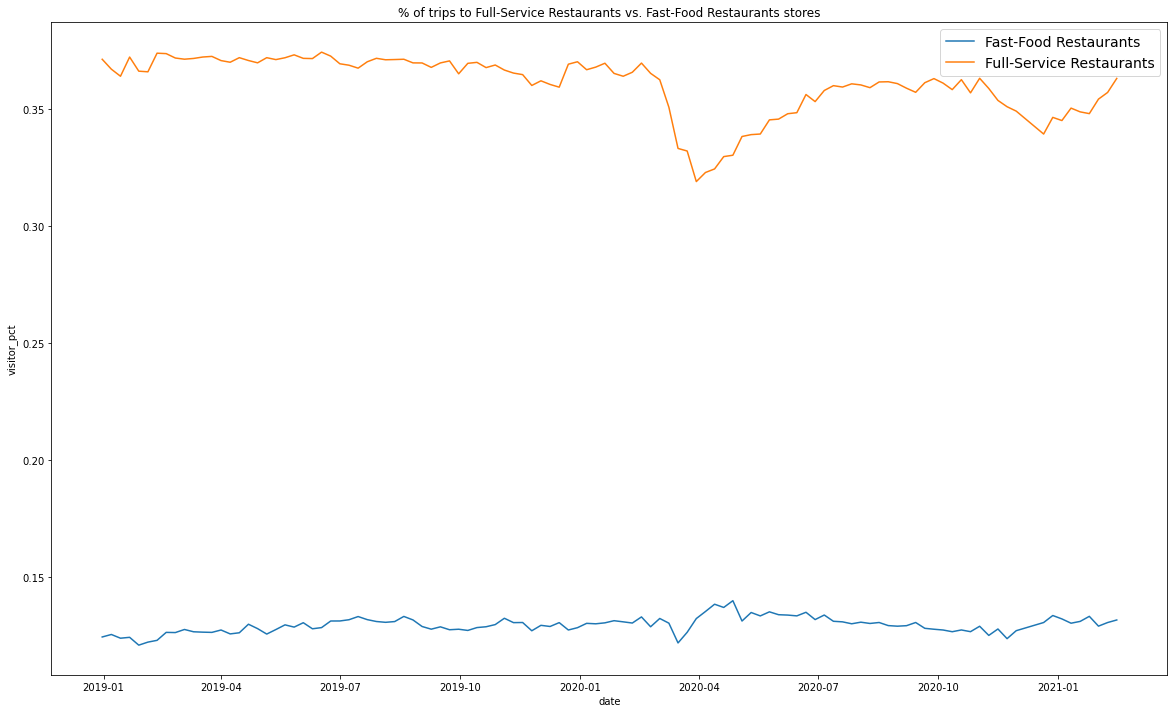

In [50]:
df_ff = df_ff.groupby(['sub_category','date']).agg({'visitor_pct':'sum','visitor_est_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= df_ff, x="date", y="visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("% of trips to Full-Service Restaurants vs. Fast-Food Restaurants stores")
plt.show()

In [51]:
df_ff_cluster_0=df_ff_cluster[df_ff_cluster['cluster']==0]
df_ff_cluster_1=df_ff_cluster[df_ff_cluster['cluster']==1]
df_ff_cluster_2=df_ff_cluster[df_ff_cluster['cluster']==2]
df_ff_cluster_3=df_ff_cluster[df_ff_cluster['cluster']==3]

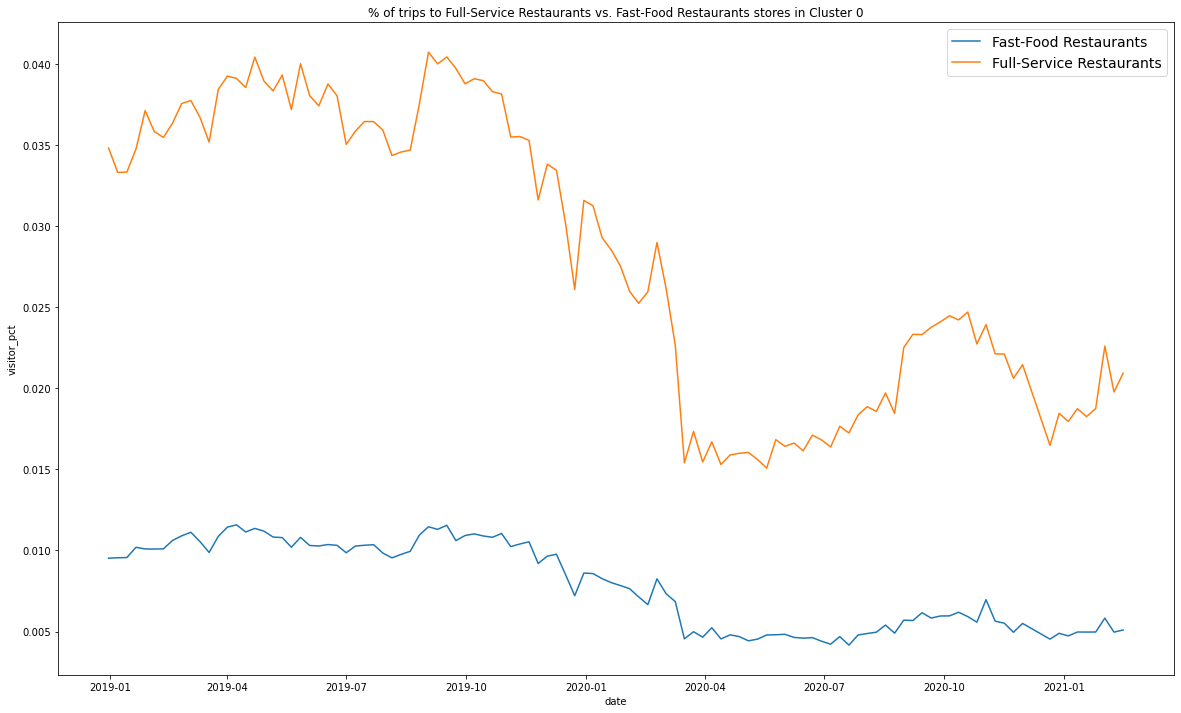

In [52]:
df_ff_cluster_0 = df_ff_cluster_0.groupby(['sub_category','date']).agg({'visitor_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= df_ff_cluster_0, x="date", y="visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("% of trips to Full-Service Restaurants vs. Fast-Food Restaurants stores in Cluster 0")
plt.show()

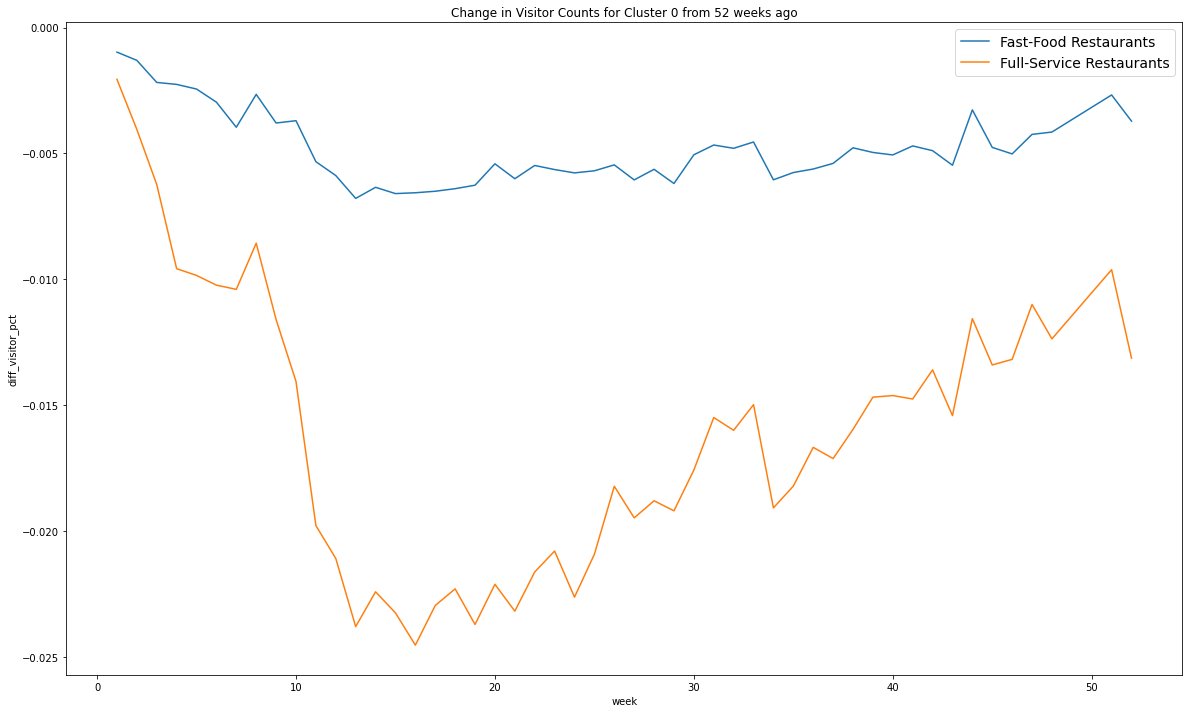

In [53]:
df_ff_cluster_0=df_ff_cluster_0.reset_index()
repair_dates(df_ff_cluster_0)
df_ff_cluster_0['year'] = df_ff_cluster_0['date'].dt.year
df_ff_cluster_0['week'] = df_ff_cluster_0['date'].dt.week

df_ff_cluster_0_2019=df_ff_cluster_0[df_ff_cluster_0.year==2019]
df_ff_cluster_0_2020=df_ff_cluster_0[df_ff_cluster_0.year==2020]

diff_df_ff_cluster_0 = pd.merge(df_ff_cluster_0_2019[['sub_category','week','visitor_pct']],df_ff_cluster_0_2020[['sub_category','week','visitor_pct']], on= ['sub_category', 'week'])
diff_df_ff_cluster_0['diff_visitor_pct']=diff_df_ff_cluster_0['visitor_pct_y']-diff_df_ff_cluster_0['visitor_pct_x']
    
plt.figure(figsize=(20,12))
sns.lineplot(data= diff_df_ff_cluster_0, x="week", y="diff_visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("Change in Visitor Counts for Cluster 0 from 52 weeks ago")
plt.show()

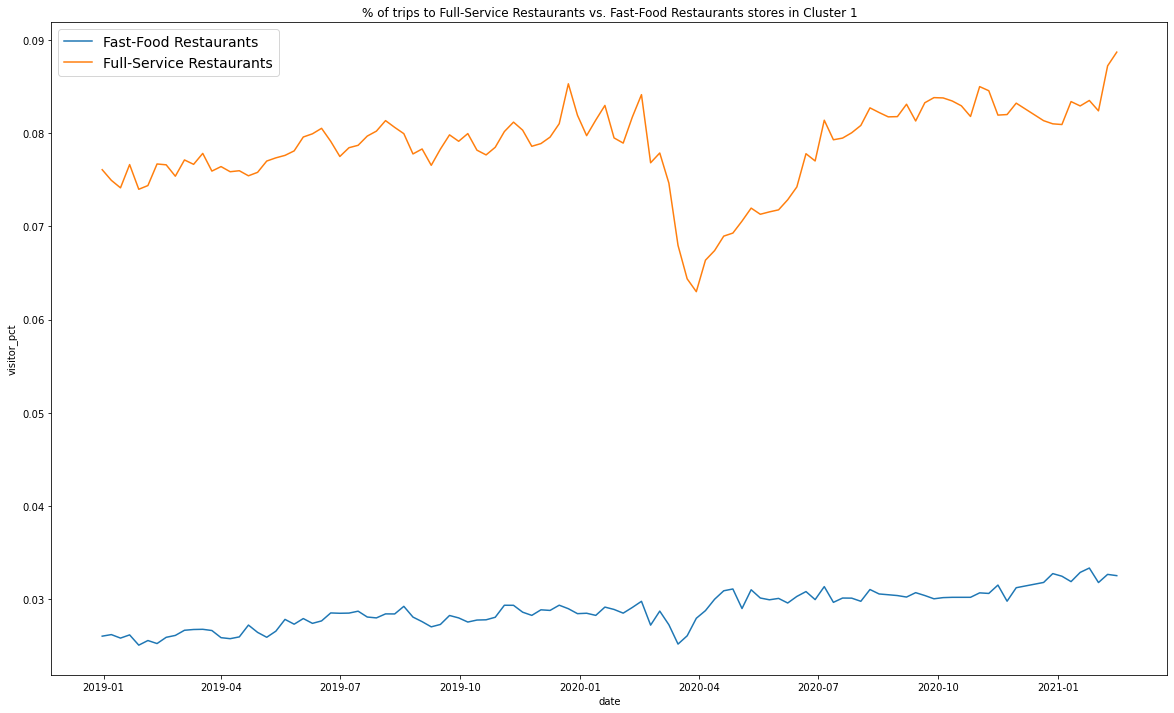

In [54]:
df_ff_cluster_1 = df_ff_cluster_1.groupby(['sub_category','date']).agg({'visitor_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= df_ff_cluster_1, x="date", y="visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("% of trips to Full-Service Restaurants vs. Fast-Food Restaurants stores in Cluster 1")
plt.show()

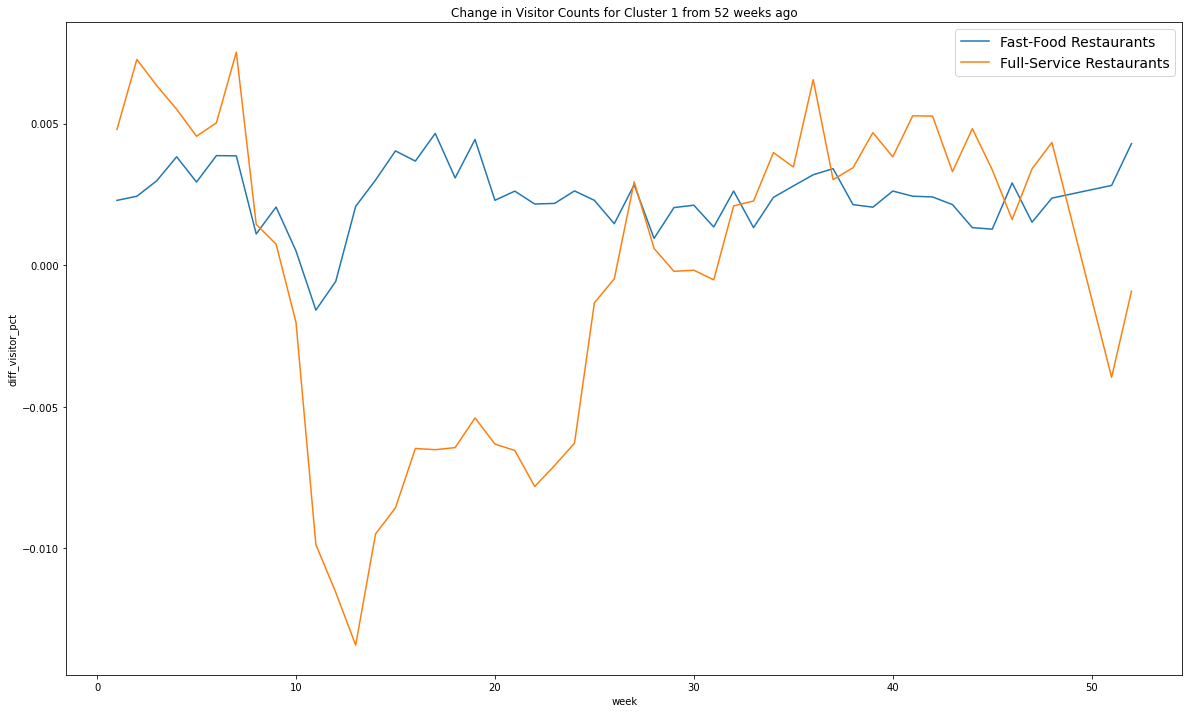

In [55]:
df_ff_cluster_1=df_ff_cluster_1.reset_index()
repair_dates(df_ff_cluster_1)
df_ff_cluster_1['year'] = df_ff_cluster_1['date'].dt.year
df_ff_cluster_1['week'] = df_ff_cluster_1['date'].dt.week

df_ff_cluster_1_2019=df_ff_cluster_1[df_ff_cluster_1.year==2019]
df_ff_cluster_1_2020=df_ff_cluster_1[df_ff_cluster_1.year==2020]

diff_df_ff_cluster_1 = pd.merge(df_ff_cluster_1_2019[['sub_category','week','visitor_pct']],df_ff_cluster_1_2020[['sub_category','week','visitor_pct']], on= ['sub_category', 'week'])
diff_df_ff_cluster_1['diff_visitor_pct']=diff_df_ff_cluster_1['visitor_pct_y']-diff_df_ff_cluster_1['visitor_pct_x']
    
plt.figure(figsize=(20,12))
sns.lineplot(data= diff_df_ff_cluster_1, x="week", y="diff_visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("Change in Visitor Counts for Cluster 1 from 52 weeks ago")
plt.show()

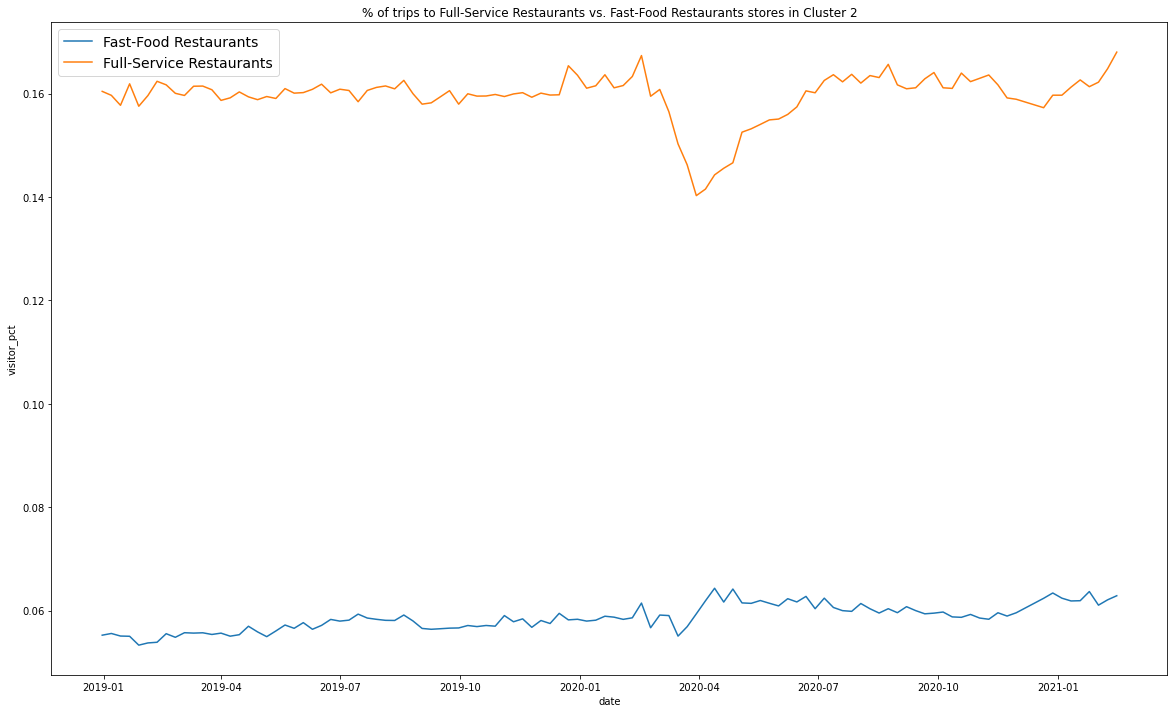

In [56]:
df_ff_cluster_2 = df_ff_cluster_2.groupby(['sub_category','date']).agg({'visitor_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= df_ff_cluster_2, x="date", y="visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("% of trips to Full-Service Restaurants vs. Fast-Food Restaurants stores in Cluster 2")
plt.show()

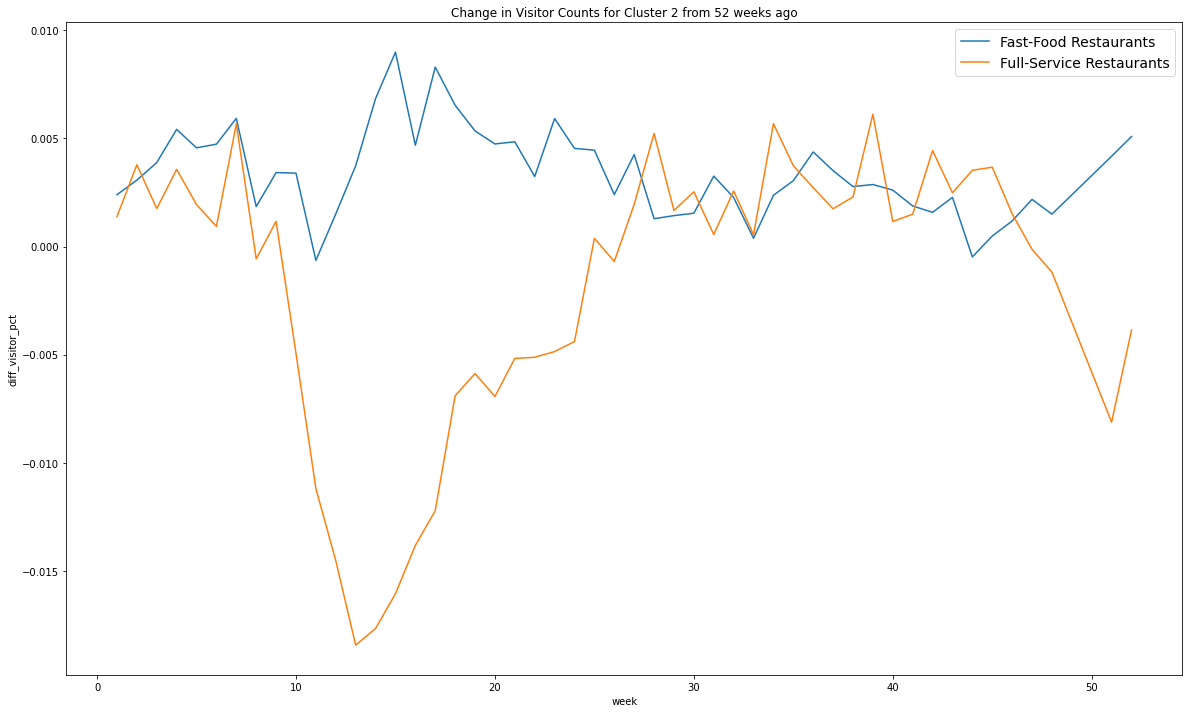

In [57]:
df_ff_cluster_2=df_ff_cluster_2.reset_index()
repair_dates(df_ff_cluster_2)
df_ff_cluster_2['year'] = df_ff_cluster_2['date'].dt.year
df_ff_cluster_2['week'] = df_ff_cluster_2['date'].dt.week

df_ff_cluster_2_2019=df_ff_cluster_2[df_ff_cluster_2.year==2019]
df_ff_cluster_2_2020=df_ff_cluster_2[df_ff_cluster_2.year==2020]

diff_df_ff_cluster_2 = pd.merge(df_ff_cluster_2_2019[['sub_category','week','visitor_pct']],df_ff_cluster_2_2020[['sub_category','week','visitor_pct']], on= ['sub_category', 'week'])
diff_df_ff_cluster_2['diff_visitor_pct']=diff_df_ff_cluster_2['visitor_pct_y']-diff_df_ff_cluster_2['visitor_pct_x']
    
plt.figure(figsize=(20,12))
sns.lineplot(data= diff_df_ff_cluster_2, x="week", y="diff_visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("Change in Visitor Counts for Cluster 2 from 52 weeks ago")
plt.show()

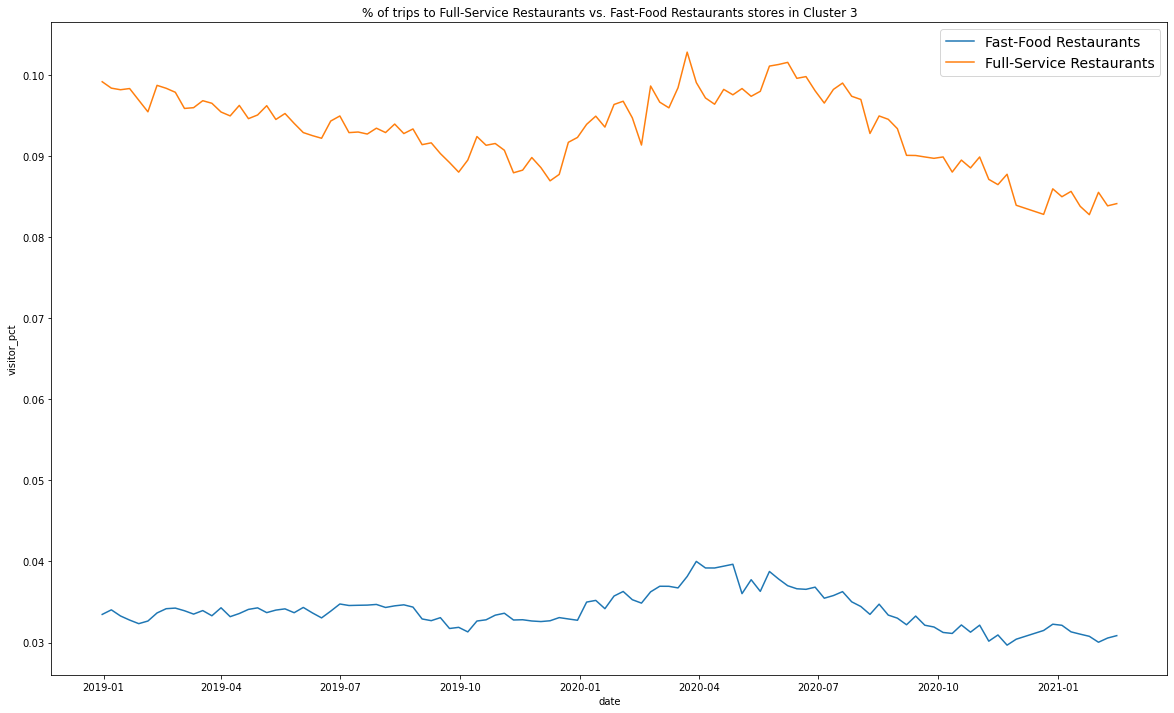

In [58]:
df_ff_cluster_3 = df_ff_cluster_3.groupby(['sub_category','date']).agg({'visitor_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= df_ff_cluster_3, x="date", y="visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("% of trips to Full-Service Restaurants vs. Fast-Food Restaurants stores in Cluster 3")
plt.show()

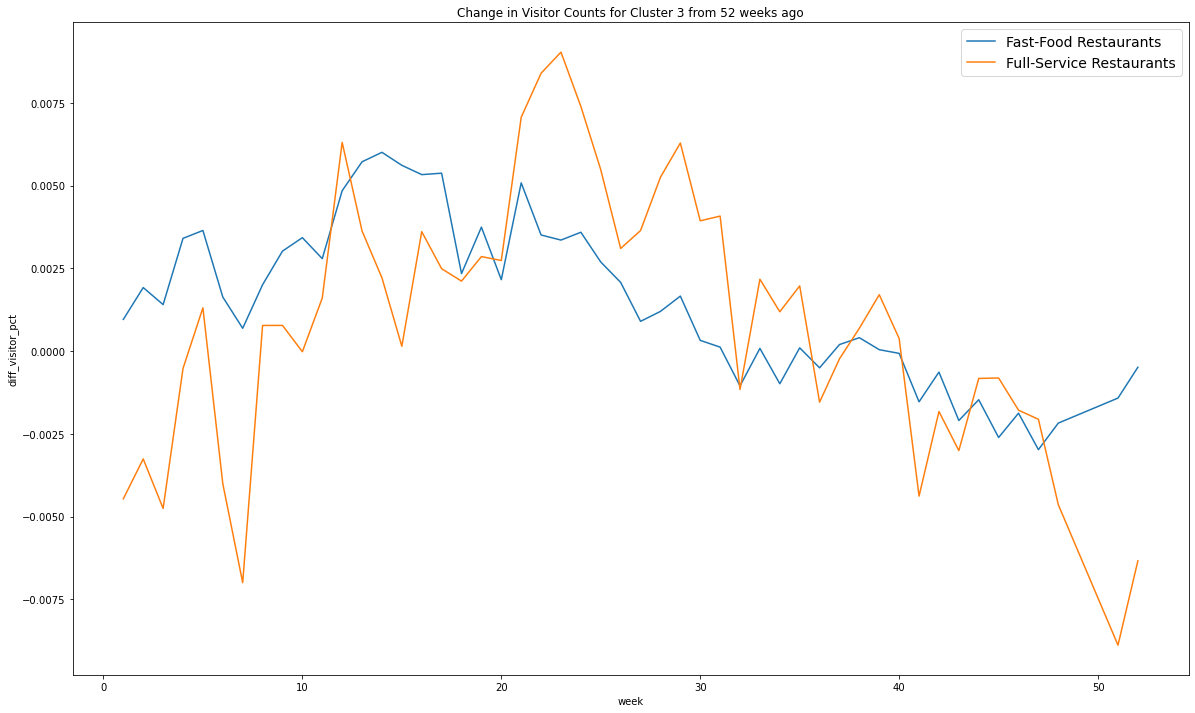

In [59]:
df_ff_cluster_3=df_ff_cluster_3.reset_index()
repair_dates(df_ff_cluster_3)
df_ff_cluster_3['year'] = df_ff_cluster_3['date'].dt.year
df_ff_cluster_3['week'] = df_ff_cluster_3['date'].dt.week

df_ff_cluster_3_2019=df_ff_cluster_3[df_ff_cluster_3.year==2019]
df_ff_cluster_3_2020=df_ff_cluster_3[df_ff_cluster_3.year==2020]

diff_df_ff_cluster_3 = pd.merge(df_ff_cluster_3_2019[['sub_category','week','visitor_pct']],df_ff_cluster_3_2020[['sub_category','week','visitor_pct']], on= ['sub_category', 'week'])
diff_df_ff_cluster_3['diff_visitor_pct']=diff_df_ff_cluster_3['visitor_pct_y']-diff_df_ff_cluster_3['visitor_pct_x']
    
plt.figure(figsize=(20,12))
sns.lineplot(data= diff_df_ff_cluster_3, x="week", y="diff_visitor_pct", hue="sub_category")
plt.legend(fontsize='14')
plt.title("Change in Visitor Counts for Cluster 3 from 52 weeks ago")
plt.show()

### Test

In [60]:
def test(df, metric, attr, class1, class2):
    """Returns the results of two-sample T-Test and K-S test on the given
    dataframes for the given attribute."""
    df1 = df[df[attr] == class1]
    df2 = df[df[attr] == class2]
    t_results = stats.ttest_ind(df1[metric].dropna(), df2[metric].dropna())
    ks_results = stats.ks_2samp(df1[metric].dropna(), df2[metric].dropna())
    return [t_results.pvalue, ks_results.pvalue]

In [82]:
df_sum = df.groupby(['sub_category','date']).agg({'visitor_pct':'sum'}) 
df_sum=df_sum.reset_index()
repair_dates(df_sum)
df_sum['year'] = df_sum['date'].dt.year
df_sum

,sub_category,date,visitor_pct,year
0,All Other General Merchandise Stores,2018-12-30 19:00:00-05:00,0.029213,2018
1,All Other General Merchandise Stores,2019-01-06 19:00:00-05:00,0.029198,2019
2,All Other General Merchandise Stores,2019-01-13 19:00:00-05:00,0.029670,2019
3,All Other General Merchandise Stores,2019-01-20 19:00:00-05:00,0.029637,2019
4,All Other General Merchandise Stores,2019-01-27 19:00:00-05:00,0.028522,2019
...,...,...,...,...
2416,Tobacco Stores,2021-01-17 19:00:00-05:00,0.006802,2021
2417,Tobacco Stores,2021-01-24 19:00:00-05:00,0.007340,2021
2418,Tobacco Stores,2021-01-31 19:00:00-05:00,0.006494,2021
2419,Tobacco Stores,2021-02-07 19:00:00-05:00,0.006802,2021


In [94]:
print('Full-Service Restaurants 2019 vs 2020', test(df_sum[df_sum['sub_category']=='Full-Service Restaurants'], 'visitor_pct', 'year', 2019, 2020))
print('Fast-Food Restaurants 2019 vs 2020', test(df_sum[df_sum['sub_category']=='Fast-Food Restaurants'], 'visitor_pct', 'year', 2019, 2020))
print('Supermarkets and Other Grocery Stores 2019 vs 2020', test(df_sum[df_sum['sub_category']=='Supermarkets and Other Grocery (except Convenience) Stores'], 'visitor_pct', 'year', 2019, 2020))
print('Delis and Convenience Stores 2019 vs 2020', test(df_sum[df_sum['sub_category']=='Delis and Convenience Stores'], 'visitor_pct', 'year', 2019, 2020))


Full-Service Restaurants 2019 vs 2020 [4.869882374939977e-14, 2.220446049250313e-15]
Fast-Food Restaurants 2019 vs 2020 [0.00014299577907271073, 0.0009731224941416095]
Supermarkets and Other Grocery Stores 2019 vs 2020 [1.6352968768387693e-18, 2.8343214490231746e-28]
Delis and Convenience Stores 2019 vs 2020 [0.00018018189525884028, 8.027574160962558e-10]


In [87]:
df_cluster=pd.merge(df,cluster,left_on='home_cbg',right_on='cbg')
df_cluster = df_cluster.groupby(['sub_category','date','cluster']).agg({'visitor_pct':'sum'})
df_cluster

visitor_pct
sub_category                         date                      cluster             
All Other General Merchandise Stores 2018-12-30 19:00:00-05:00 0           0.001157
                                                               1           0.006048
                                                               2           0.013320
                                                               3           0.008656
                                     2019-01-06 19:00:00-05:00 0           0.001032
...                                                                             ...
Tobacco Stores                       2021-02-07 19:00:00-05:00 3           0.001399
                                     2021-02-14 19:00:00-05:00 0           0.000261
                                                               1           0.001774
                                                               2           0.003307
                                                               3           0.001433

[9663 rows x 1 columns]

In [88]:
#df_sum = df.groupby(['sub_category','date','cluster']).agg({'visitor_pct':'sum'}) 
df_cluster=df_cluster.reset_index()
repair_dates(df_cluster)
df_cluster['year'] = df_cluster['date'].dt.year
df_cluster

,sub_category,date,cluster,visitor_pct,year
0,All Other General Merchandise Stores,2018-12-30 19:00:00-05:00,0,0.001157,2018
1,All Other General Merchandise Stores,2018-12-30 19:00:00-05:00,1,0.006048,2018
2,All Other General Merchandise Stores,2018-12-30 19:00:00-05:00,2,0.013320,2018
3,All Other General Merchandise Stores,2018-12-30 19:00:00-05:00,3,0.008656,2018
4,All Other General Merchandise Stores,2019-01-06 19:00:00-05:00,0,0.001032,2019
...,...,...,...,...,...
9658,Tobacco Stores,2021-02-07 19:00:00-05:00,3,0.001399,2021
9659,Tobacco Stores,2021-02-14 19:00:00-05:00,0,0.000261,2021
9660,Tobacco Stores,2021-02-14 19:00:00-05:00,1,0.001774,2021
9661,Tobacco Stores,2021-02-14 19:00:00-05:00,2,0.003307,2021


In [93]:
print('Full-Service Restaurants & Cluster 0', test(df_cluster[(df_cluster['cluster']==0)&(df_cluster['sub_category']=='Full-Service Restaurants')], 'visitor_pct', 'year', 2019, 2020))
print('Full-Service Restaurants & Cluster 1', test(df_cluster[(df_cluster['cluster']==1)&(df_cluster['sub_category']=='Full-Service Restaurants')], 'visitor_pct', 'year', 2019, 2020))
print('Full-Service Restaurants & Cluster 2', test(df_cluster[(df_cluster['cluster']==2)&(df_cluster['sub_category']=='Full-Service Restaurants')], 'visitor_pct', 'year', 2019, 2020))
print('Full-Service Restaurants & Cluster 3', test(df_cluster[(df_cluster['cluster']==3)&(df_cluster['sub_category']=='Full-Service Restaurants')], 'visitor_pct', 'year', 2019, 2020))
print('\n')
print('Fast-Food Restaurants & Cluster 0', test(df_cluster[(df_cluster['cluster']==0)&(df_cluster['sub_category']=='Fast-Food Restaurants')], 'visitor_pct', 'year', 2019, 2020))
print('Fast-Food Restaurants & Cluster 1', test(df_cluster[(df_cluster['cluster']==1)&(df_cluster['sub_category']=='Fast-Food Restaurants')], 'visitor_pct', 'year', 2019, 2020))
print('Fast-Food Restaurants & Cluster 2', test(df_cluster[(df_cluster['cluster']==2)&(df_cluster['sub_category']=='Fast-Food Restaurants')], 'visitor_pct', 'year', 2019, 2020))
print('Fast-Food Restaurants & Cluster 3', test(df_cluster[(df_cluster['cluster']==3)&(df_cluster['sub_category']=='Fast-Food Restaurants')], 'visitor_pct', 'year', 2019, 2020))
print('\n')
print('Supermarkets & Cluster 0', test(df_cluster[(df_cluster['cluster']==0)&(df_cluster['sub_category']=='Supermarkets and Other Grocery (except Convenience) Stores')], 'visitor_pct', 'year', 2019, 2020))
print('Supermarkets & Cluster 1', test(df_cluster[(df_cluster['cluster']==1)&(df_cluster['sub_category']=='Supermarkets and Other Grocery (except Convenience) Stores')], 'visitor_pct', 'year', 2019, 2020))
print('Supermarkets & Cluster 2', test(df_cluster[(df_cluster['cluster']==2)&(df_cluster['sub_category']=='Supermarkets and Other Grocery (except Convenience) Stores')], 'visitor_pct', 'year', 2019, 2020))
print('Supermarkets & Cluster 3', test(df_cluster[(df_cluster['cluster']==3)&(df_cluster['sub_category']=='Supermarkets and Other Grocery (except Convenience) Stores')], 'visitor_pct', 'year', 2019, 2020))
print('\n')
print('Convenience Stores & Cluster 0', test(df_cluster[(df_cluster['cluster']==0)&(df_cluster['sub_category']=='Delis and Convenience Stores')], 'visitor_pct', 'year', 2019, 2020))
print('Convenience Stores & Cluster 1', test(df_cluster[(df_cluster['cluster']==1)&(df_cluster['sub_category']=='Delis and Convenience Stores')], 'visitor_pct', 'year', 2019, 2020))
print('Convenience Stores & Cluster 2', test(df_cluster[(df_cluster['cluster']==2)&(df_cluster['sub_category']=='Delis and Convenience Stores')], 'visitor_pct', 'year', 2019, 2020))
print('Convenience Stores & Cluster 3', test(df_cluster[(df_cluster['cluster']==3)&(df_cluster['sub_category']=='Delis and Convenience Stores')], 'visitor_pct', 'year', 2019, 2020))
print('\n')

Full-Service Restaurants & Cluster 0 [3.7438890866851124e-39, 8.446879454256686e-36]
Full-Service Restaurants & Cluster 1 [0.7515762989243537, 0.0002988013908200582]
Full-Service Restaurants & Cluster 2 [0.06441422979733749, 0.007423173607849387]
Full-Service Restaurants & Cluster 3 [0.19774500945648565, 0.0063188252267123435]


Fast-Food Restaurants & Cluster 0 [4.323530550920921e-42, 8.446879454256686e-36]
Fast-Food Restaurants & Cluster 1 [7.91483505979654e-15, 3.029798634202052e-13]
Fast-Food Restaurants & Cluster 2 [9.456938578909114e-17, 4.551914400963142e-15]
Fast-Food Restaurants & Cluster 3 [0.000496642306838834, 1.6562846760770356e-08]


Supermarkets & Cluster 0 [0.8257364268639894, 0.0712609465149171]
Supermarkets & Cluster 1 [2.7665389044751497e-22, 9.162133056132401e-26]
Supermarkets & Cluster 2 [3.059091535642939e-19, 2.132935747006153e-31]
Supermarkets & Cluster 3 [7.894800368925635e-15, 8.514222684964547e-24]


Convenience Stores & Cluster 0 [6.9320725361863e-36, 2.1329